# Introduction
The purpose of this notebook is to evaluate an epigenotyping technology targeting imprinted genes. 
The capture is targeted on a set of regions identified in humans and mice as being imprinted.

Several capture protocols to be compared on 8 individuals:
  - Agilent (2 protocols) + Illumina
  - NEB + Twist (2 protocols) + Illumina

### Imports
Import libraries

In [21]:
#File import
import glob
import os
import ntpath
import sys

# Data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import uniform, randint

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.figure_factory as ff
import plotly.offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Setting
Write settings here.

In [22]:
dict_twist1_error = {"AB72740530":"FR17MAG201513026", "AB7273400_":"FR17MAG201611897", "AB72735095":"FR17MAG201613767", "AB72735091":"FR17MAG201814095", "AB72240443":"FR17MAG201814099", "AB72727642":"FR17MAG201814115", "AB72727678":"FR17MAG201814130", "AB63081783":"FR35HJ3201702774"}
dict_twist1 = {"AB72740530":"FR17MAG201513026", "AB72734005":"FR17MAG201611897", "AB72735095":"FR17MAG201613767", "AB72735091":"FR17MAG201814095", "AB72240443":"FR17MAG201814099", "AB72727642":"FR17MAG201814115", "AB72727678":"FR17MAG201814130", "AB63081783":"FR35HJ3201702774"}
dict_twist2 = {"AB72740530":"FR17MAG201513026", "AB72734005":"FR17MAG201611897", "AB72735095":"FR17MAG201613767", "AB72735091":"FR17MAG201814095", "AB72740443":"FR17MAG201814099", "AB72727642":"FR17MAG201814115", "AB72727678":"FR17MAG201814130", "AB63081783":"FR35HJ3201702774"}
dict_agilent1 = {"AB72740532":"FR17MAG201513026", "AB72680336":"FR17MAG201611897", "AB72734224":"FR17MAG201613767", "AB72740525":"FR17MAG201814095", "AB72740498":"FR17MAG201814099", "AB72734233":"FR17MAG201814115", "AB72733986":"FR17MAG201814130", "AB63083986":"FR35HJ3201702774"}

dict_panels_with_error = {"twist1":dict_twist1_error, "twist2":dict_twist2, "agilent1":dict_agilent1}
dict_panels = {"twist1":dict_twist1, "twist2":dict_twist2, "agilent1":dict_agilent1}

base_dir = os.getcwd()

list_scaffold = ["AEMK02000682.1", "AEMK02000328.1", "AEMK02000452.1", "AEMK02000602.1"]

# Analysis/Functions


## Utils

In [20]:
def import_files(filename):
    files = glob.glob("**/*{}".format(filename), recursive=True)

    return files


def get_barre_code(files):

    barre_code = [ntpath.basename(f)[0:10] for f in files]

    return barre_code


def get_output_name(base_dir, folder, filename):
    output = os.path.join(base_dir, "results",
                          folder, filename)

    return output


def get_output_html_svg(fig, base_dir, folder, filename):

    output_html = get_output_name( base_dir, folder, "{}.html".format(filename))
    output_svg = get_output_name(base_dir, folder, "{}.svg".format(filename))

    fig.write_html(output_html)
    fig.write_image(output_svg)

## Fraction of targeted bases for a given depth

In [4]:
def plot_target_region_cov(filename, dict_id):

    files = import_files("{}.txt".format(filename))
    colnames = ['all', 'depth', 'nb_bases', 'size_target', 'perc_depth']
    dfs = [
        pd.read_csv(f, header=None, delimiter="\t", names=colnames)
        for f in files
    ]

    barre_code = get_barre_code(files)

    for df in dfs:
        df['perc_cumul'] = (1 - df['perc_depth'].cumsum())

    fig = go.Figure()

    # Add traces
    i = 0
    for df in dfs:
        bc = barre_code[i]
        fig.add_trace(
            go.Scatter(x=df['depth'],
                       y=df['perc_cumul'],
                       mode='lines',
                       name=dict_id[bc]))
        i += 1

    fig.update_layout(
        title="Target Region Coverage for {}".format(filename),
        yaxis_title="Fraction of capture target bases \u2265 depth",
        xaxis_title="Depth")
    fig.show()
    get_output_html_svg(fig, base_dir, "fraction_cov",
                        "fraction_cov_{}".format(filename))
    return fig


def plot_target_region_cov_panels(filenames_dict, is_covered):
    a = "covered" if is_covered else "total"
    for file, dict_panel in filenames_dict.items():
        plot_target_region_cov("{}_{}".format(a, file), dict_panel)

## Off-target reads

In [5]:
def plot_off_target_comparison(dict_panels):

    fig = go.Figure()

    for panel, dict_panel in dict_panels.items():
        files = import_files("table_off_target_{}.txt".format(panel))
        colnames = ['sample_bc', 'read_total', 'read_offtarget']
        df = pd.read_csv(files[0], header=None, delimiter="\t", names=colnames)

        list_id = [dict_panel[i] for i in df['sample_bc']]
        fig.add_trace(
            go.Bar(x=list_id,
                   y=(df['read_offtarget'] / df['read_total']),
                   name=panel))

    fig.update_layout(title="Comparison of reads off-target between panels",
                      yaxis_title="Percentage of reads off-target",
                      xaxis_title="Sample",
                      yaxis_tickformat='.1%')
    fig.update_layout()

    fig.show()
    get_output_html_svg(fig, base_dir, "off_target",
                        "comparison_off_target_perc")


def plot_off_target_reads(panel, dict_panel):
    files = import_files("table_off_target_{}.txt".format(panel))
    colnames = ['sample_bc', 'read_total', 'read_offtarget']
    df = pd.read_csv(files[0], header=None, delimiter="\t", names=colnames)

    list_id = [dict_panel[i] for i in df['sample_bc']]
    fig = go.Figure()

    fig.add_trace(
        go.Bar(x=list_id,
               y=(df['read_offtarget'] / df['read_total']),
               name="Off target reads"))

    fig.update_layout(
        title="Percentage of reads off-target for {}".format(panel),
        yaxis_title="Percentage of reads off-target",
        xaxis_title="Sample",
        yaxis_tickformat=',.1%',
        yaxis_range=[0, 1])

    fig.update_layout()
    fig.show()
    get_output_html_svg(fig, base_dir, "off_target",
                        "off_target_reads_{}".format(panel))


def plot_off_target_reads_panels(filenames_dict):

    for file, dict_panel in filenames_dict.items():
        plot_off_target_reads("{}".format(file), dict_panel)

## Mean coverage per region

In [6]:
def import_bedgraph(panel):
    files_region = import_files("expected.csv")
    df_region = pd.read_csv(files_region[0], delimiter=";")
    df_region = df_region[["chrom", "chromStart", "chromEnd", "name"]]

    files_GC = import_files("GC_rate.txt".format(panel))
    df_GC = pd.read_csv(files_GC[0], delimiter="\t")
    df_GC.rename(columns={
        "#1_usercol": "chrom",
        "2_usercol": "chromStart",
        "3_usercol": "chromEnd",
        "6_pct_gc": "pc_GC"
    },
                 inplace=True)
    df_GC = df_GC[["chrom", "chromStart", "chromEnd", "pc_GC"]]

    files = import_files(
        "meanDepth_targeted_covered_{}.bedgraph".format(panel))
    colnames = ['chrom', 'chromStart', 'chromEnd', 'brin', 'mean_depth']
    barre_code = get_barre_code(files)

    dfs = []
    for f in files:
        df1 = pd.read_csv(f, header=None, delimiter="\t", names=colnames)
        df2 = pd.merge(df1, df_region, on=["chrom", "chromStart", "chromEnd"])
        df = pd.merge(df2, df_GC, on=["chrom", "chromStart", "chromEnd"])
        df["size"] = df["chromEnd"] - df["chromStart"]
        df.sort_values(by=['size'], inplace=True)
        dfs.append(df)

        df_all = dfs[0][["name", "size"]]
        i = 0
        list_column = []
        for df in dfs:
            df_all["mean_depth{}".format(i)] = df["mean_depth"]
            list_column.append("mean_depth{}".format(i))
            i += 1
        df_all['mean_all'] = df_all[list_column].mean(axis=1)
        df_all.sort_values(by=['size'], inplace=True)

    return dfs, df_all, barre_code


def plot_mean_depth(panel, dict_panel):

    dfs, df_all, barre_code = import_bedgraph(panel)

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    i = 0
    for df in dfs:
        bc = barre_code[i]
        fig.add_trace(go.Scatter(x=df["name"],
                                 y=(df['mean_depth']),
                                 name=dict_panel[bc]),
                      secondary_y=False)
        i += 1

    fig.add_trace(go.Scatter(x=df_all["name"],
                             y=df_all['mean_all'],
                             name="Mean"),
                  secondary_y=False)

    fig.add_trace(go.Scatter(x=df["name"],
                             y=df["pc_GC"],
                             name="GC rate",
                             marker_color="grey"),
                  secondary_y=True)

    fig.update_layout(title="Mean depth per region for {}".format(panel),
                      xaxis_title="Expected region",
                      height=600,
                      width=1100)

    fig.update_yaxes(title_text="Mean depth", secondary_y=False)
    fig.update_yaxes(title_text="GC %", secondary_y=True)

    fig.show()
    get_output_html_svg(fig, base_dir, "mean_depth",
                        "mean_depth_target_region_{}".format(panel))


def plot_mean_depth_panels(filenames_dict):

    for file, dict_panel in filenames_dict.items():
        plot_mean_depth("{}".format(file), dict_panel)


def plot_mean_depth_comparison(filenames_dict):

    dfs_mean = {}
    for panel, dict_panel in filenames_dict.items():
        dfs_mean[panel] = import_bedgraph(panel)[1]

    fig = go.Figure()

    for panel, df in dfs_mean.items():

        fig.add_trace(go.Bar(x=df["name"], y=(df['mean_all']), name=panel))

    fig.show()

    fig.update_layout(
        title="Comparison of mean depth per region between panels".format(
            panel),
        yaxis_title="Mean depth",
        xaxis_title="Expected region")

    get_output_html_svg(fig, base_dir, "mean_depth", "comparison_mean_depth")

## Mean coverage per annotation type

In [7]:
def create_box_plot_cov_annotation(panel):
    files = import_files("annotation_type_{}.txt".format(panel))
    df = pd.read_csv(files[0], delimiter="\t", usecols=[0, 1, 2, 3])

    fig = go.Figure()
    fig.add_trace(
        go.Box(y=df['mean_cov_introns'],
               name='Introns',
               boxpoints='all',
               boxmean=True))
    fig.add_trace(
        go.Box(y=df['mean_cov_exons'],
               name='Exons',
               boxpoints='all',
               boxmean=True))
    fig.add_trace(
        go.Box(y=df['mean_cov_cpg'],
               name='CpG island',
               boxpoints='all',
               boxmean=True))

    fig.update_layout(
        title="Mean coverage per type of annotation for {}".format(panel),
        yaxis_title="Mean depth",
        xaxis_title="Annotation type")

    get_output_html_svg(fig, base_dir, "mean_depth_annotation",
                        "coverage_annotation_type_{}".format(panel))

    fig.show()


def create_box_plot_cov_annotation_panels(filenames_dict):

    for file, dict_panel in filenames_dict.items():
        create_box_plot_cov_annotation(file)

## Methylation percentage distribution

In [8]:
def add_region_name(files, df_region):
    colnames = [
        'chrom', 'chromStart', 'chromEnd', 'strand', 'feature_cov', 'base_cov',
        'length_region', 'fraction_cov'
    ]
    dfs = []
    for f in files:
        df1 = pd.read_csv(f, header=None, delimiter="\t", names=colnames)
        df = pd.merge(df1, df_region, on=["chrom", "chromStart", "chromEnd"])
        dfs.append(df)
    return dfs


def mean_methyl_cov(dfs, mean):
    df_mean = dfs[0][["name"]]
    i = 0
    for df in dfs:
        df_mean["mean_{}".format(i)] = df["{}".format(mean)]
        i += 1
    df_mean['mean_all'] = df_mean.mean(axis=1)
    return df_mean

In [9]:
def create_barchart_perc_methyl(panel):

    
    files_region = import_files("expected.csv")
    df_region = pd.read_csv(files_region[0], delimiter=";")
    df_region = df_region[["chrom", "chromStart", "chromEnd", "name"]]
    
    files_30_70 = import_files("30_70_{}.bed".format(panel))
    files_inf30 = import_files("inf30_{}.bed".format(panel))
    files_sup70 = import_files("sup70_{}.bed".format(panel))

    dfs_30_70 = add_region_name(files_30_70, df_region)
    dfs_inf30 = add_region_name(files_inf30, df_region)
    dfs_sup70 = add_region_name(files_sup70, df_region)

    dfs_final = []
    for (df_30_70, df_inf30, df_sup70) in zip(dfs_30_70, dfs_inf30, dfs_sup70):
        df = df_30_70[["chrom", "chromStart", "chromEnd", "name"]]
        df["meth_30_70"] = df_30_70["feature_cov"]
        df["meth_inf30"] = df_inf30["feature_cov"]
        df["meth_sup70"] = df_sup70["feature_cov"]
        dfs_final.append(df)
        
    df_mean_30_70 = mean_methyl_cov(dfs_final, "meth_30_70")
    df_mean_inf30 = mean_methyl_cov(dfs_final, "meth_inf30")
    df_mean_sup70 = mean_methyl_cov(dfs_final, "meth_sup70")

    fig = go.Figure()

    nb_meth_10reads = df_mean_30_70['mean_all'] + df_mean_inf30[
        'mean_all'] + df_mean_sup70['mean_all']

    fig.add_trace(
        go.Bar(x=df_mean_30_70['name'],
               y=df_mean_30_70['mean_all'] / nb_meth_10reads,
               name="Mean PoM between 30 and 70",
               marker=dict(color="gold")))

    fig.add_trace(
        go.Bar(x=df_mean_sup70['name'],
               y=df_mean_sup70['mean_all'] / nb_meth_10reads,
               name="Mean PoM above 70",
               marker=dict(color="#e5e4e2")))

    fig.add_trace(
        go.Bar(x=df_mean_inf30['name'],
               y=df_mean_inf30['mean_all'] / nb_meth_10reads,
               name="Mean PoM bellow 30",
               marker=dict(color="grey")))

    fig.update_layout(
        title=
        "Distribution of cytosine across targeted regions for {} (> 10 reads)".
        format(panel),
        yaxis_title="Percentage of cytosine",
        xaxis_title="Region",
        yaxis_tickformat=',.1%',
        barmode="stack")
    
    get_output_html_svg(fig, base_dir, "methylation_perc",
                        "methylation_perc_{}".format(panel))
    fig.show()
    
def create_barchart_perc_methyl_panels(filenames_dict):

    for file, dict_panel in filenames_dict.items():
        create_barchart_perc_methyl(file)

## Manhattan plot offtarget

In [40]:
def create_dataframe_offtarget(file):
    df_bed= pd.read_csv(file, header=None, delimiter="\t", names=["chrom", "chromStart", "chromEnd", "cov"], low_memory = False)
    
    df_bed["size"]= df_bed["chromEnd"] - df_bed["chromStart"]
    for i in df_bed.index:
        if i == 0:
            start_value = df_bed._get_value(i, 'chromStart')
            df_bed._set_value(i, 'start', start_value)

            end_value = df_bed._get_value(i, 'chromEnd')
            df_bed._set_value(i, 'end', end_value)
        else:
            start_temp = df_bed._get_value(i-1, 'end')
            df_bed._set_value(i, 'start', start_temp)
            end_temp = df_bed._get_value(i, 'start') + df_bed._get_value(i, 'size')
            df_bed._set_value(i, 'end', end_temp)
        
    df_bed["start_int"] = pd.to_numeric(df_bed.start, downcast='integer')
    df_bed["end_int"] = pd.to_numeric(df_bed.end, downcast='integer')
    
    return df_bed
        
    
    
def create_offtarget_plot(file, panel, dict_panel, is_unknown, is_max, list_scaffold, threshold, barre_code):
    
    df = create_dataframe_offtarget(file)
    #for chunk in pd.read_csv(file, header=None, delimiter="\t", names=["chrom", "chromStart", "chromEnd", "cov"], low_memory = False, chunksize=1000):
        #df_bed = pd.concat([df_bed, chunk], ignore_index=True)
    #df_bed= pd.read_csv(file, header=None, delimiter="\t", names=["chrom", "chromStart", "chromEnd", "cov"], low_memory = False) 
    #start = file.find('\\') + 1
    #end = file.find('_bedtools', start)
    #barre_code = file[start:end]
    
    
    list_chrom = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', 'X', 'Y', 'MT']
    
    if is_unknown:
        df_bed = df
        df_bed.loc[~(df_bed["chrom"].isin(list_chrom)), "chrom"] = "UN"
        file_name = "Off_target_distrib_{}_{}_.png".format(dict_panel[barre_code], panel)
        out_put_png = os.path.join(base_dir, "results",
                          "manhattan_plot", file_name)
    else:
        if not list_scaffold:
            df_bed = df[~(df["chrom"].isin(list_chrom))]
            df_bed.reset_index(inplace=True)
            file_name = "Off_target_distrib_scaffolds_{}_{}.png".format(dict_panel[barre_code], panel)
        else:
            df_bed = df[df["chrom"].isin(list_scaffold)]
            df_bed.reset_index(inplace=True)
            file_name = "Off_target_distrib_list_scaffolds_{}_{}.png".format(dict_panel[barre_code], panel)
        
    df_bed["i"] = df_bed["start_int"]
    chrom_df=df_bed.groupby('chrom')['i'].median()
    
    if is_max:
        max_df=df_bed.groupby("chrom", as_index=False)["cov"].max()
        mean = df_bed["cov"].mean()
        list_chrom_max = max_df[max_df["cov"] > mean*threshold]["chrom"].unique().tolist()
        print(list_chrom_max)
        df_bed = df_bed[df_bed["chrom"].isin(list_chrom_max)]
    
    plot = sns.relplot(data=df_bed, x='i', y='cov', aspect=3.7, 
                   hue='chrom', palette = 'bright', legend=None) 
    plot.ax.set_xlabel('chrom'); plot.ax.set_xticks(chrom_df)
    plot.ax.set_xticklabels(chrom_df.index)
    plot.fig.suptitle('Manhattan plot {} {}'.format(panel, dict_panel[barre_code]))
    plot.savefig(out_put_png) 

def create_offtarget_plot_all(panel, dict_panel, is_unknown, ismax, list_scaffold, threshold):
    files = import_files("_distrib_{}.bedgraph".format(panel))
    
    barre_codes = get_barre_code(files)
    i=0
    for file in files:
        create_offtarget_plot(file, panel, dict_panel, is_unknown, ismax, list_scaffold, threshold, barre_codes[i])
        i+=1

# Results

## Fraction of bases for a given depth

### Target region covered 

In [10]:
plot_target_region_cov_panels(dict_panels, True)

### Target region total

In [11]:
plot_target_region_cov_panels(dict_panels, False)

## Off-target reads

### Off-target reads comparison

In [12]:
plot_off_target_comparison(dict_panels_with_error)

### Off-target reads individual graph

In [26]:
plot_off_target_reads_panels(dict_panels_with_error)

## Mean coverage per region

### Mean coverage per region per panel

In [27]:
plot_mean_depth_panels(dict_panels)

### Mean coverage per region comparison between panels

In [28]:
plot_mean_depth_comparison(dict_panels)

## Mean coverage per annotation type

In [29]:
create_box_plot_cov_annotation_panels(dict_panels)

## Methylation percentage distribution

In [30]:
create_barchart_perc_methyl_panels(dict_panels)

## Manhattan plot offtarget

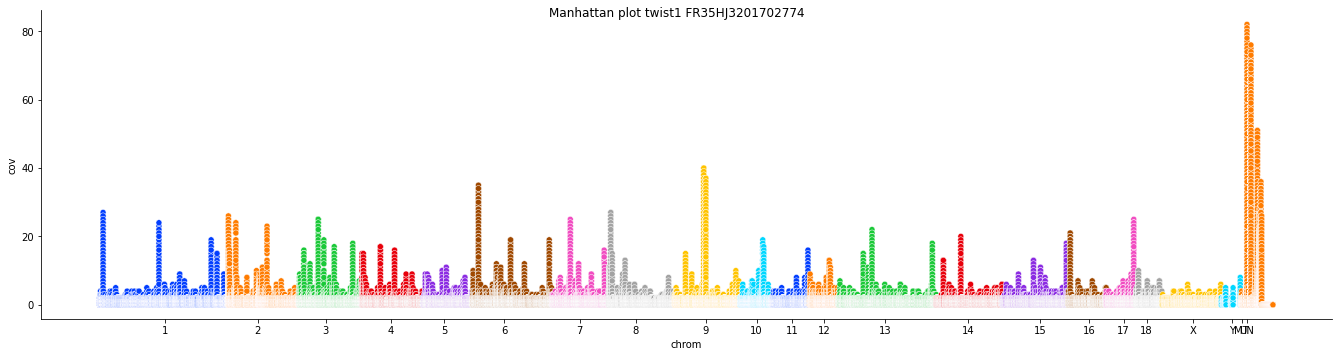

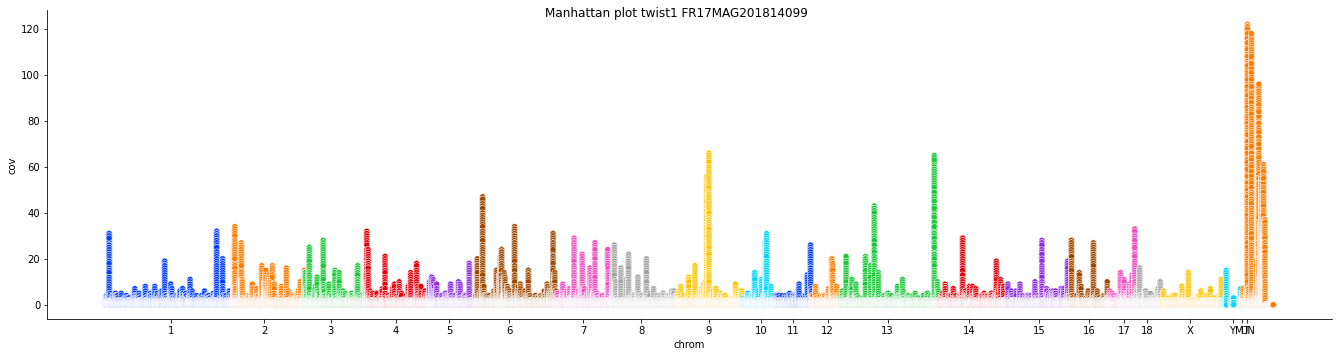

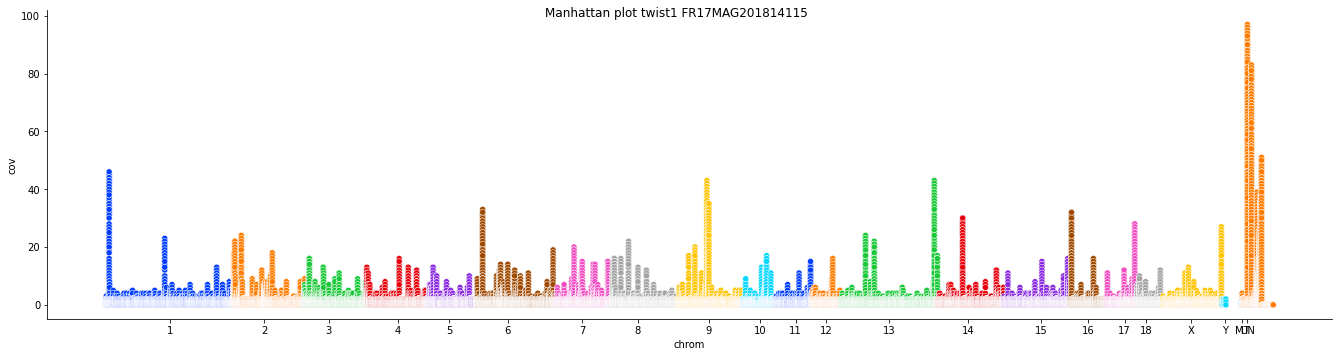

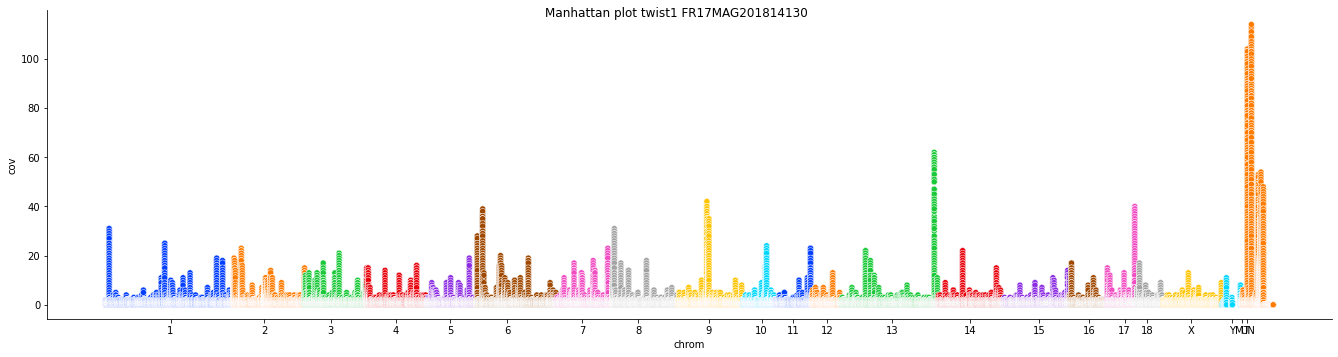

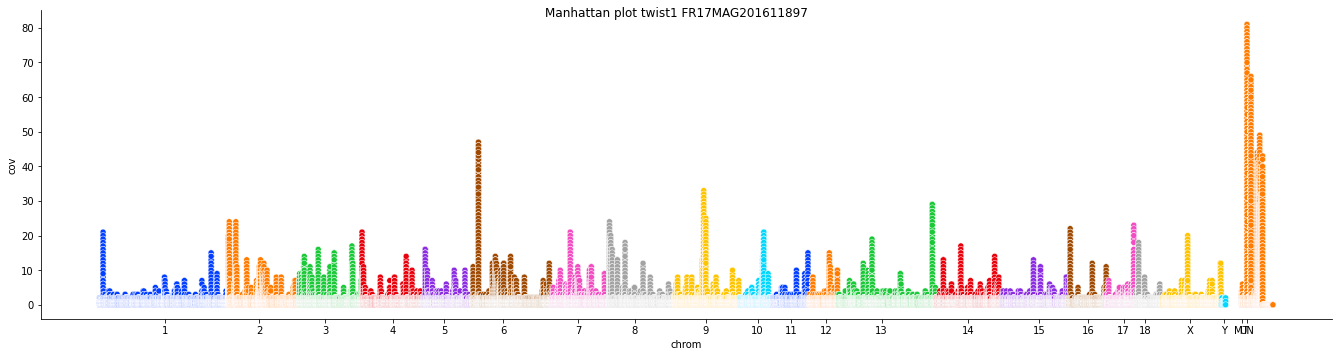

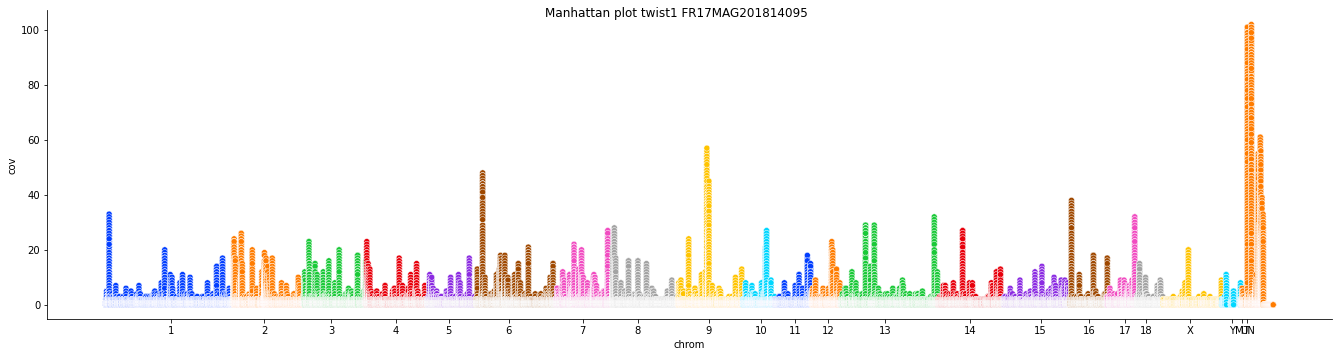

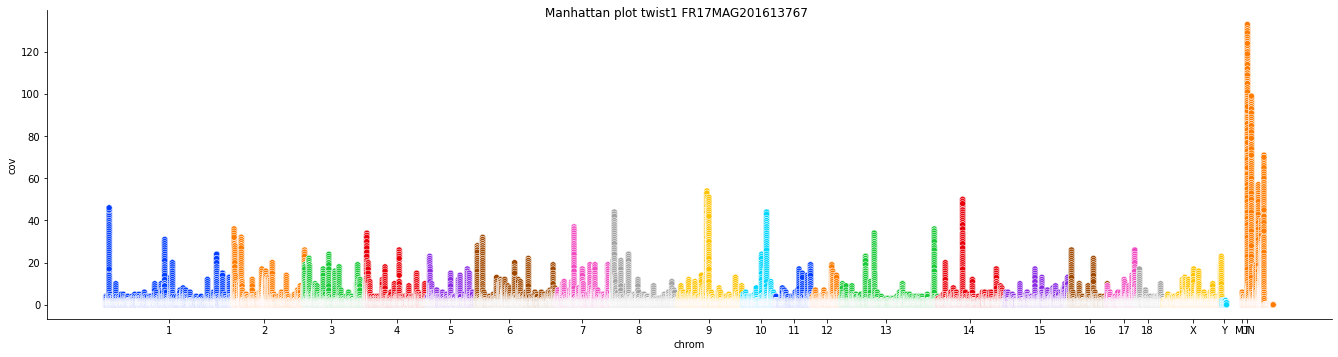

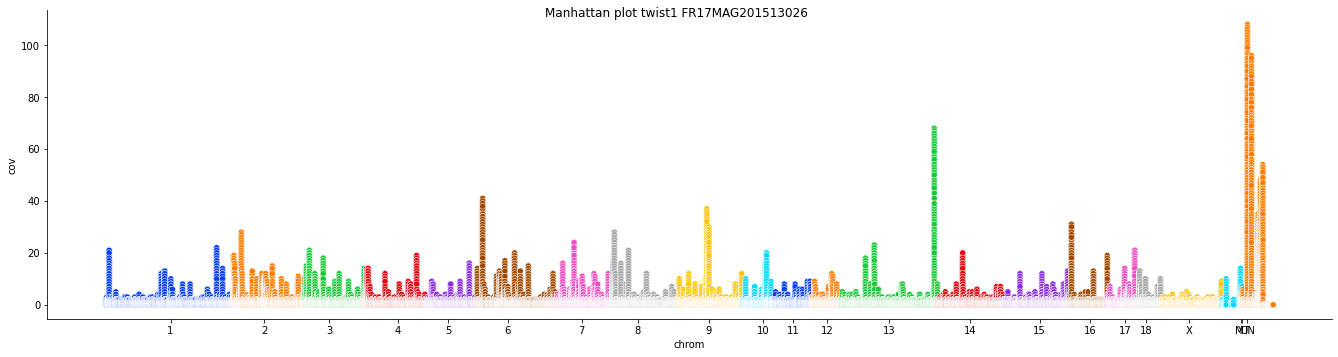

In [44]:
dict_twist1_error = {"AB72740530":"FR17MAG201513026", "AB7273400_":"FR17MAG201611897", "AB72735095":"FR17MAG201613767", "AB72735091":"FR17MAG201814095", "AB72240443":"FR17MAG201814099", "AB72727642":"FR17MAG201814115", "AB72727678":"FR17MAG201814130", "AB63081783":"FR35HJ3201702774"}

create_offtarget_plot_all("twist1", dict_twist1_error, True, False, list_scaffold, 3)

NameError: name 'panel' is not defined

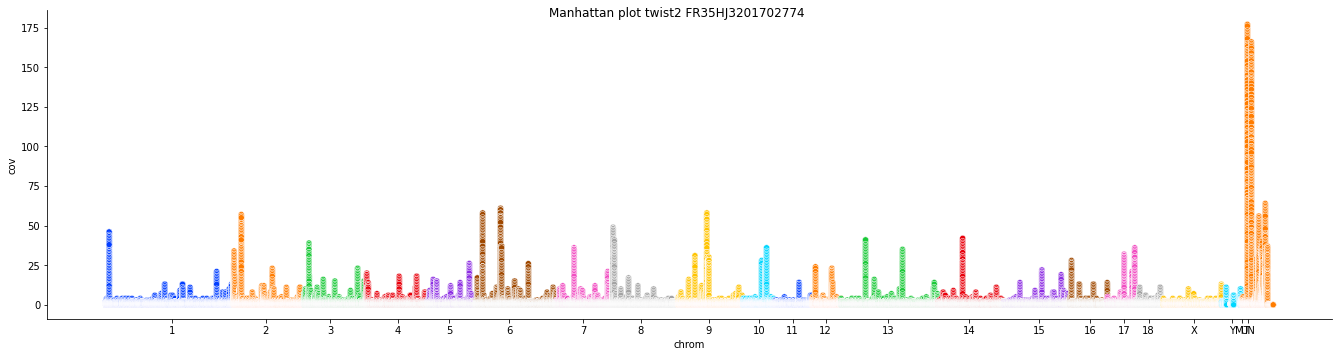

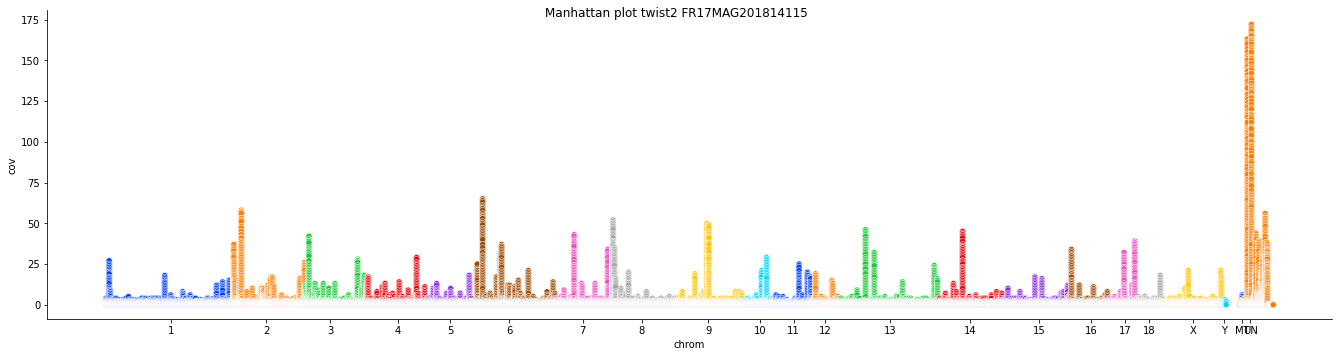

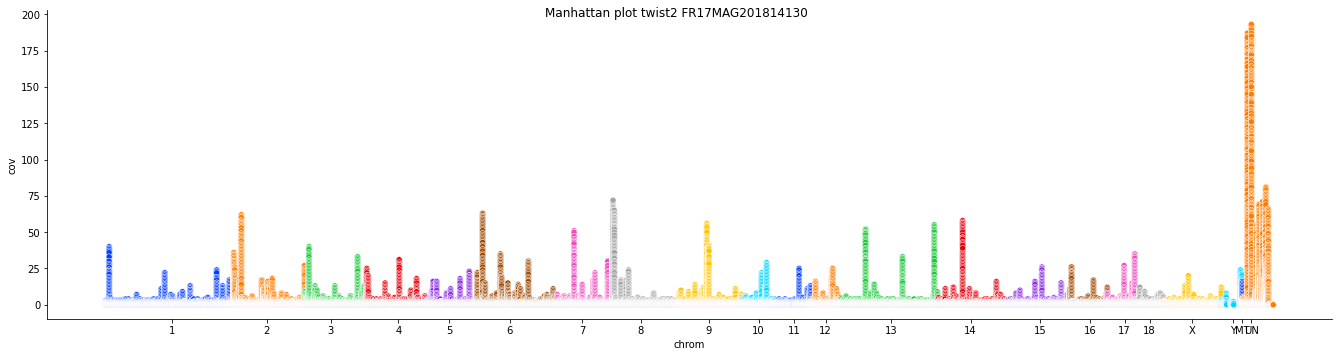

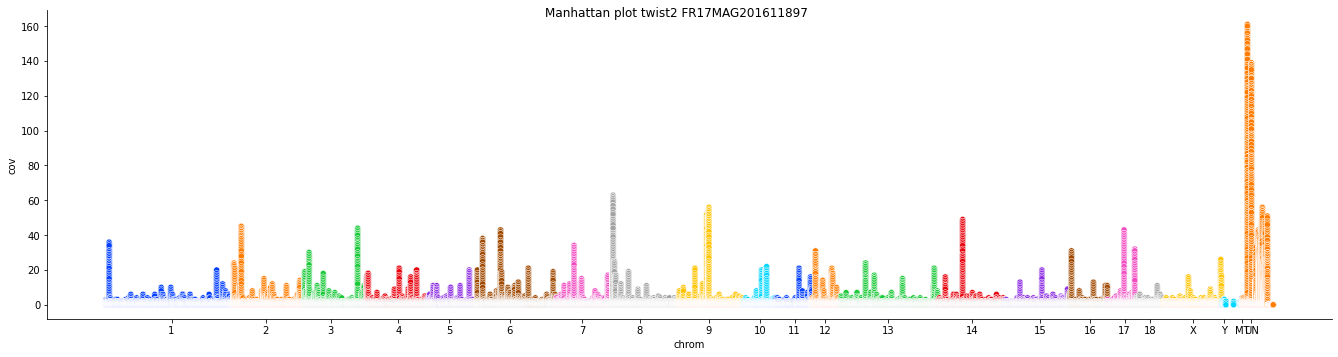

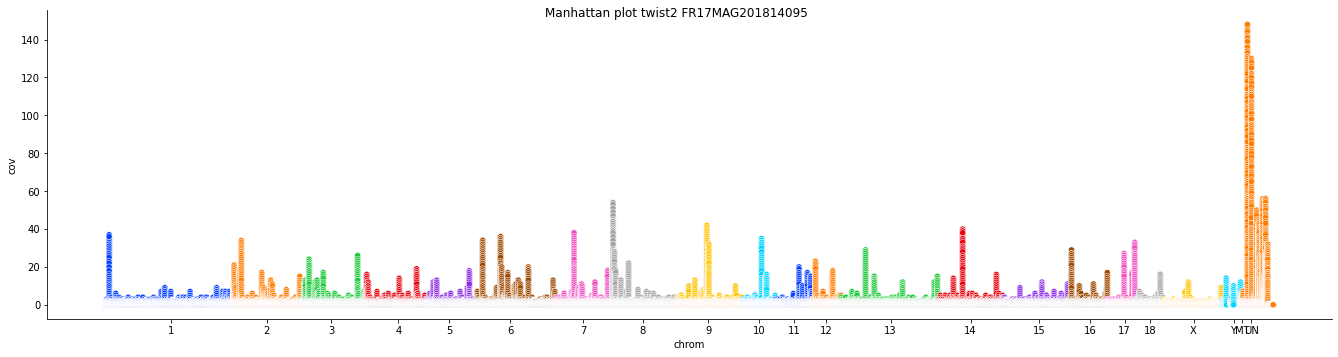

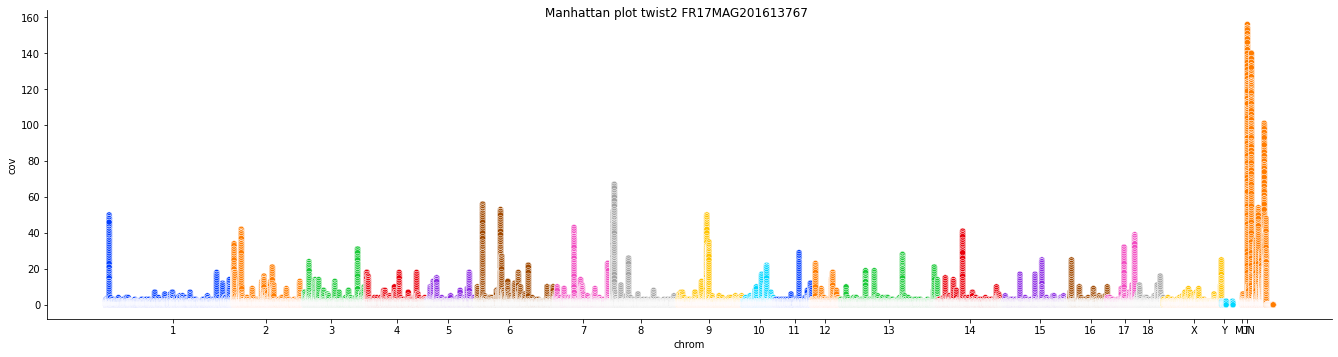

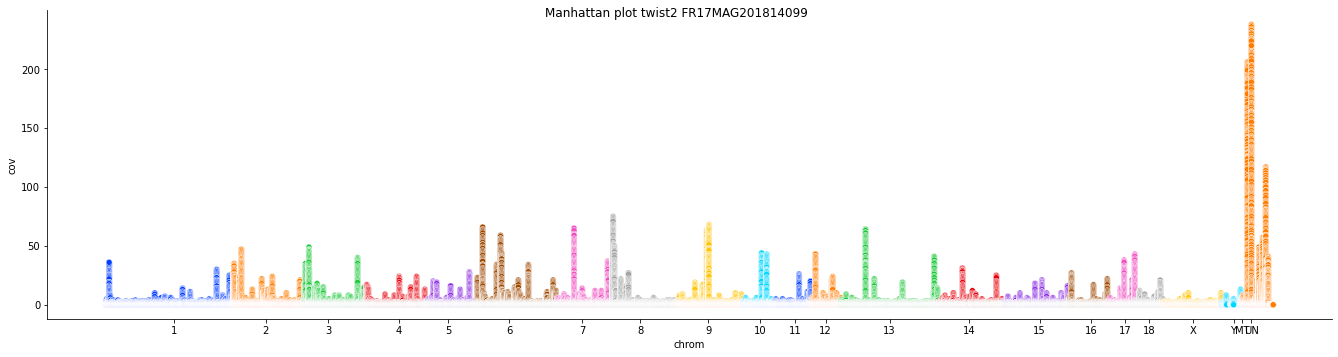

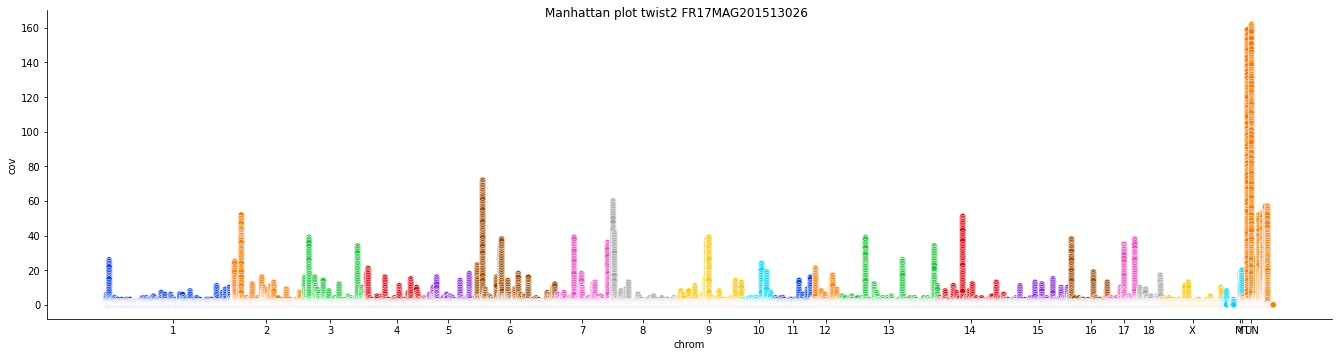

In [45]:
dict_twist2 = {"AB72740530":"FR17MAG201513026", "AB72734005":"FR17MAG201611897", "AB72735095":"FR17MAG201613767", "AB72735091":"FR17MAG201814095", "AB72740443":"FR17MAG201814099", "AB72727642":"FR17MAG201814115", "AB72727678":"FR17MAG201814130", "AB63081783":"FR35HJ3201702774"}

create_offtarget_plot_all("twist2", dict_twist2, True, False, list_scaffold, 3)
panel, dict_panel, is_unknown, is_max, list_scaffold, threshold

In [ ]:
dict_agilent1 = {"AB72740532":"FR17MAG201513026", "AB72680336":"FR17MAG201611897", "AB72734224":"FR17MAG201613767", "AB72740525":"FR17MAG201814095", "AB72740498":"FR17MAG201814099", "AB72734233":"FR17MAG201814115", "AB72733986":"FR17MAG201814130", "AB63083986":"FR35HJ3201702774"}

create_offtarget_plot_all("agilent1", dict_agilent1, True, list_scaffold)

# Conclusions and Next Steps
Summarize findings here